# ValidationPredictiveDistributions
This notebook is to validate the equations for the predictive distributions. The validation is performed by using Monte-Carlo sampling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce # only in Python 3
import pickle

NMon = 2000 #number of samples for Monte-Carlo Sampling.

## 1. Predictive distribution for regression with multiple annotators
The likelihood function for regression problems is given as:
$$p(\mathbf{Y}|\mathbf{f}) = \prod_{n}\prod_{r\sim n}\mathcal{N}(y_n^r|t_n,v_{r,n}),$$
where $t_n = f_{1,n}$ is the gold standard, and $v_{r,n} = v_r(x_n) = \exp(f_{l_r}(x_n))$, with $l_r\in \{2,\dots , J\}$. Here, $J=R+1$ is the number of latent functions (LFs), and $R$ is the number of annotators. 

### 1.1 Posterior for $\mathbf{t}$
Due to $\mathbf{t} = \mathbf{f}_{1}$, the posterior distribution for $t_*$ corresponds to $q(f_{1*})$.

### 1.2 Posterior for $\mathbf{v}_{r}$
In this case, since $\mathbf{v}_{r} = \exp(\mathbf{f}_{l_r})$, the posterior distribution for $v_{r*}$ follows a log-normal distribution with parameters $\mu_{l_r*}$ and $\sigma^2_{l_r*}$, which respectively correspond to the mean and variance of $q(f_{l_r*})$. In this sense, the mean and variance of $v_{r*}$ are given as
$$\mathbb{E}[v_{r*}] = \int \exp(f_{l_r*}) q(f_{l_r*})df_{l_r*} = \exp\left(\mu_{l_r*} + \frac{\sigma^2_{l_r*}}{2}\right).$$
$$\operatorname{Var}[v_{r*}] = \int \left(\exp(f_{l_r*})-\mathbb{E}[v_{r*}]\right)^2 q(f_{l_r*})df_{l_r*} = \exp\left(2\mu_{l_r*} + \sigma^2_{l_r*}\right)\left(\exp(\sigma^2_{l_r*}) - 1\right).$$


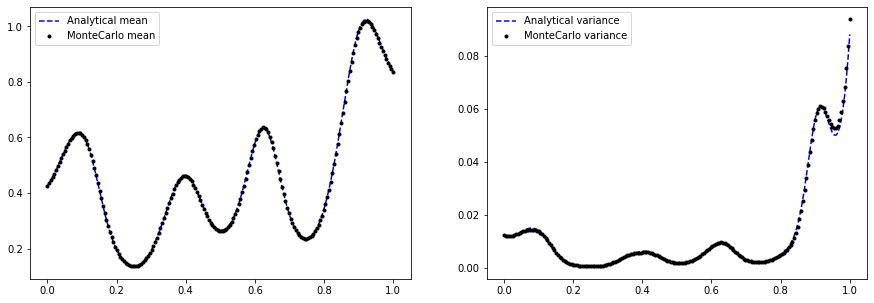

In [2]:
# Loading the data
with open('PosteriorsReg', 'rb') as f:
    posteriors = pickle.load(f)
X =  posteriors[2]
N = len(X)
mreg = posteriors[0]
Kreg = posteriors[1]
vreg = np.diag(Kreg).reshape((N,1))
freg = np.dot(np.linalg.cholesky(Kreg+1e-6*np.eye(N)), np.random.randn(N,NMon)) + mreg

# Samples for $v_r$
vr = np.exp(freg)

#the analytical mean and variance
m_vr = np.exp(mreg + vreg/2)
v_vr = np.exp(2*mreg + vreg)*(np.exp(vreg) - 1)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(X, m_vr, 'b--', label='Analytical mean')
plt.plot(X, np.mean(vr, axis=1), 'k.', label='MonteCarlo mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, v_vr, 'b--', label='Analytical variance')
plt.plot(X, np.var(vr, axis=1), 'k.', label='MonteCarlo variance')
plt.legend()
plt.show()

## 2. Predictive distribution for binary classification with multiple annotators
The likelihood function for binary classification problems is given as:
$$p(\mathbf{Y}|\mathbf{f}) = \prod_{n}\prod_{r\sim n}\left(\zeta_n^{y_n^r}(1-\zeta_n)^{1-y_n^r}\right)^{\lambda_{r,n}},$$
where, $\zeta_n = \sigma\left(f_1(x_n)\right)$, and $\lambda_{r,n} = \lambda^r(x_n) =\sigma(f_{l_r}(x_n))$, with $r\in \left\{1, \dots R\right\}$, and $l_r = r+1 \in \left\{2, \dots J\right\}$; hence, the number of required LFs is $J=R+1$. Here, $\sigma(\cdot)$ is the Sigmoid function
$$\sigma(a) = \frac{1}{1 + \exp(-a)}$$.

### 2.1 Posterior for $\mathbf{\zeta}$ and $\mathbf{\lambda}_r$
In this case, both $\mathbf{\zeta}$ and $\mathbf{\lambda}_r$ are computed by applying a Sigmoid function over the latent functions $\{\sigma(\mathbf{f}_1), \dots , \sigma(\mathbf{f}_J)\}$. Thus, the mean for $\sigma(f_{*})$ can be approximated as (See "Pattern recognition and machine learning" Eq. 4.154 and Eq 4.155)
$$\mathbb{E}[\sigma(f_{j*})] = \int \sigma(f_{j*}) q(f_{j*})df_{j*} \approx \sigma\left(\frac{\mu_j}{\sqrt{1 + \frac{\pi\sigma_j^2}{8}}}\right),$$
or by using the Gauss-Hermite quadrature, where $\mu_j$ and $\sigma_j^2$ are respectively the mean and variance of $q(f_{j*})$. For the variance of $\sigma(f_{*})$, we use the expression $\operatorname{Var}[\sigma(f_{j*})] = \mathbb{E}[\sigma(f_{j*})^2] - \mathbb{E}[\sigma(f_{j*})]^2$; hence, we need to compute $\mathbb{E}[\sigma(f_{j*})^2]$, which is given as
$$\mathbb{E}[\sigma(f_{j*})^2] = \int \sigma(f_{j*})^2 q(f_{j*})df_{j*}.$$
The above integral has not closed solution, we approximate it by using the Gauss-Hermite (GH) quadrature.

In [3]:
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

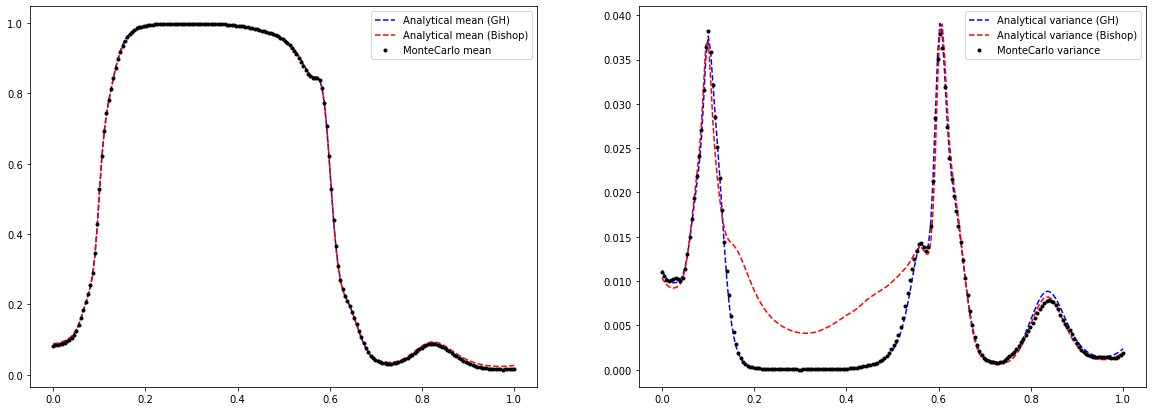

In [4]:
# Loading the data
with open('PosteriorsBiC', 'rb') as f:
    posteriors = pickle.load(f)

X =  posteriors[2]
N = len(X)
mb = posteriors[0]
Kb = posteriors[1]
vb = np.diag(Kb).reshape((N,1))
fb = np.dot(np.linalg.cholesky(Kb+1e-6*np.eye(N)), np.random.randn(N,NMon)) + mb

sig_fj = Sigmoid(fb) #samples

#Gauss-Hermite quadrature
T = 20 #number of points for the Gauss-Hermite approximation
gh_f, gh_w = np.polynomial.hermite.hermgauss(T)
gh_w = gh_w / np.sqrt(np.pi)

#the analytic mean 
m_sig_fjB = Sigmoid(mb/(np.sqrt(1+np.pi*vb/8)))
x = gh_f[None, :] * np.sqrt(2. * vb) + mb
sig_fj_1 = Sigmoid(x)
m_sig_fj = sig_fj_1.dot(gh_w[:,None])

#the analytic variance 
x = gh_f[None, :] * np.sqrt(2. * vb) + mb
sig_fj_2 = sig_fj_1**2
sig_fj_2 = sig_fj_2.dot(gh_w[:,None])
v_sig_fj = sig_fj_2 - m_sig_fj**2
v_sig_fjB = sig_fj_2 - m_sig_fjB**2


plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.plot(X, m_sig_fj, 'b--', label='Analytical mean (GH)')
plt.plot(X, m_sig_fjB, 'r--', label='Analytical mean (Bishop)')
plt.plot(X, np.mean(sig_fj, axis=1), 'k.', label='MonteCarlo mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, v_sig_fj, 'b--', label='Analytical variance (GH)')
plt.plot(X, v_sig_fjB, 'r--', label='Analytical variance (Bishop)')
plt.plot(X, np.var(sig_fj, axis=1), 'k.', label='MonteCarlo variance')
plt.legend()
plt.show()

## 3. Predictive distribution for multi-class classification with multiple annotators
The likelihood function for multi-class classification problems is given as:
$$p(\mathbf{Y}|\mathbf{f}) = \prod_{n}\prod_{r\sim n}\left(\prod_{k=1}^{K}\zeta_{k,n}^{c_{k,n}^r}\right)^{\lambda_n^r}\left(\frac{1}{K}\right)^{1-\lambda_n^r},$$
where $K$ is the number of classes, and $c_n^r$ is the representation of $y_n^r$ using the $1$-of-$K$; thus, $c_{k,n}^r$ is $1$ when $k$ matches the label given by the $r$-th labeler to the sample $n$, and $0$ otherwise. Besides
$$\zeta_{k,n} = \operatorname{Softmax}\left(f_k(x_n)\right) =\frac{\exp(f_{k,n})}{\sum_{j=1}^{K}\exp(f_{j,n})}, \;\forall k \in\left\{1,\dots , K\right\},$$
and $\lambda_{r,n} = \lambda^r(x_n) =\sigma(f_{l_r}(x_n))$, with $r\in \left\{1, \dots R\right\}$, and $l_r = K+r \in \left\{K+1, \dots J\right\}$; hence, the number of required LFs are $J=K+R$.

### 3.1 Posterior for $\mathbf{\lambda}_r$
$\mathbf{\lambda}_r$ has the same distrbution of the binary classification problem. Hence, its mean and variance can be computed as in Section 4.1

### 3.2 Posterior for $\mathbf{\zeta}_k$
Each $\mathbf{\zeta}_k$ is computed by applying the Softmax function over each function $f_{k,n}$, $\forall k \in\left\{1,\dots , K\right\}$. Accordingly, the mean for $\mathbf{\zeta}_{k*}$ can be approximated as 
$$\mathbb{E}[\zeta_{k*}] = \int \operatorname{Softmax}(f_{k*}) q(f_{1*})\dots q(f_{K*}) df_{1*}\dots df_{K*}.$$
This integral is approximated by using the Gauss-Hermite approximation. For the variance of $\mathbf{\zeta}_{k*}$, we use the expression $\operatorname{Var}[\mathbf{\zeta}_{k*}] = \mathbb{E}[\mathbf{\zeta}_{k*}^2] - \mathbb{E}[\mathbf{\zeta}_{k*}]^2$; hence, we need to compute $\mathbb{E}[\mathbf{\zeta}_{k*}^2]$, which is given as
$$\mathbb{E}[\mathbf{\zeta}_{k*}^2] = \int \operatorname{Softmax}(f_{k*})^2 q(f_{1*})\dots q(f_{K*}) df_{1*}\dots df_{K*}.$$
The above integral has not closed solution, we approximate it by using the Gauss-Hermite quadrature.

In [5]:
def Softmax(A):
    num = np.exp(A)
    den = np.sum(num, 1)
    den = den[:,np.newaxis]
    zeta_k = num/den
    return zeta_k

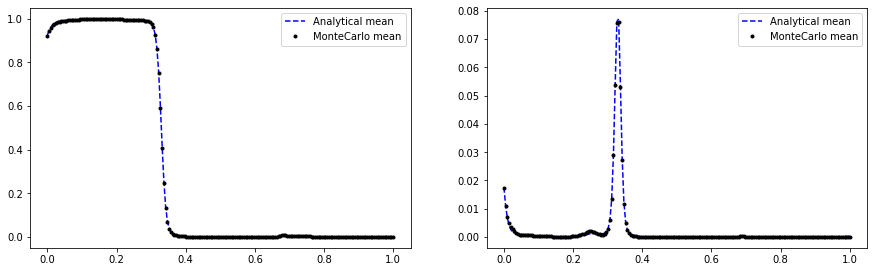

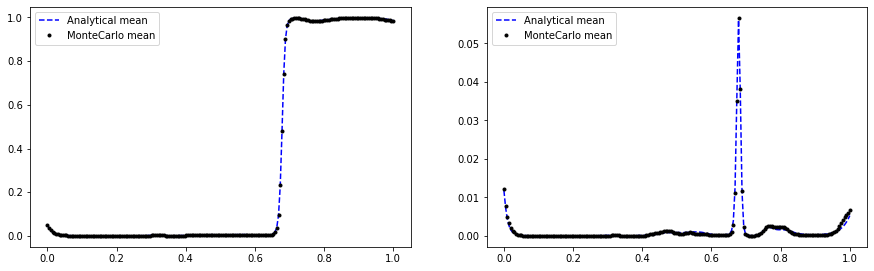

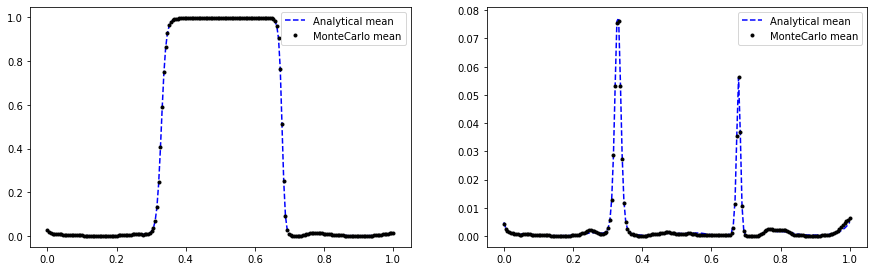

In [6]:
# Loading the data
with open('Posteriors', 'rb') as f:
    posteriors = pickle.load(f)
K = 3 # Functions  for a multiclass problem with 3 classes
X  = posteriors[6]
N = len(X)
m1 = posteriors[0]
K1 = posteriors[1]
v1 = np.diag(K1).reshape((N,1))
m2 = posteriors[2]
K2 = posteriors[3]
v2 = np.diag(K2).reshape((N,1))
m3 = posteriors[4]
K3 = posteriors[5]
v3 = np.diag(K3).reshape((N,1))


NMon = 1000
f1 = np.dot(np.linalg.cholesky(K1+1e-6*np.eye(N)), np.random.randn(N,NMon)) + m1
f2 = np.dot(np.linalg.cholesky(K2+1e-6*np.eye(N)), np.random.randn(N,NMon)) + m2
f3 = np.dot(np.linalg.cholesky(K3+1e-6*np.eye(N)), np.random.randn(N,NMon)) + m3


#we define some samles for $\sigma(f_j)$
M = np.concatenate((m1, m2, m3), axis=1)
V = np.concatenate((v1, v2, v3), axis=1)

#MonteCarlo mean and variance
Zeta1 = np.zeros(f1.shape)
Zeta2 = np.zeros(f1.shape)
Zeta3 = np.zeros(f1.shape)
for it in range(NMon):
    F_ = np.concatenate((f1[:,it:it+1], f2[:,it:it+1], f3[:,it:it+1]), axis=1)
    aux = Softmax(F_)
    Zeta1[:,it] = aux[:,0]
    Zeta2[:,it] = aux[:,1]
    Zeta3[:,it] = aux[:,2]


mean_zeta = np.concatenate((np.mean(Zeta1, axis=1).reshape((N,1)),\
                            np.mean(Zeta2, axis=1).reshape((N,1)),\
                            np.mean(Zeta3, axis=1).reshape((N,1))), axis=1)
var_zeta = np.concatenate((np.var(Zeta1, axis=1).reshape((N,1)),\
                           np.var(Zeta2, axis=1).reshape((N,1)),\
                           np.var(Zeta3, axis=1).reshape((N,1))), axis=1)

# Gauss-Hermite Approximation ###################
T = 20 #number of points for the Gauss-Hermite approximation
gh_f, gh_w = np.polynomial.hermite.hermgauss(T)


expanded_F_tuples = []
grid_tuple = [M.shape[0]]
for k in range(K):
    grid_tuple.append(gh_f.shape[0])
    expanded_fd_tuple = [1]*(K+1)
    expanded_fd_tuple[k+1] = gh_f.shape[0]
    expanded_F_tuples.append(tuple(expanded_fd_tuple))

mv_tuple = [1]*(K+1)
mv_tuple[0] = M.shape[0]
mv_tuple = tuple(mv_tuple)

 # building, normalizing and reshaping the grids
F = np.zeros((reduce(lambda x, y: x * y, grid_tuple),K))
for d in range(K):
    fd = np.zeros(tuple(grid_tuple))
    fd[:] = np.reshape(gh_f, expanded_F_tuples[d])*np.sqrt(2*np.reshape(V[:,d],mv_tuple)) \
            + np.reshape(M[:,d],mv_tuple)
    F[:,d,None] = fd.reshape(reduce(lambda x, y: x * y, grid_tuple), -1, order='C')

# Analytic mean
S_f = Softmax(F)
E_S_fk = np.zeros((N,K))
for k in range(K):
    S_fk = S_f[:,k].reshape(tuple(grid_tuple))
    E_S_fk1 = S_fk.dot(gh_w) / np.sqrt(np.pi)
    for kl in range(K-1):
        E_S_fk1 = E_S_fk1.dot(gh_w) / np.sqrt(np.pi)
    E_S_fk[:,k] = E_S_fk1

# Analytic variance
S_f_2 = S_f**2
V_S_fk = np.zeros((N,K))
for k in range(K):
    V_fk = S_f_2[:,k].reshape(tuple(grid_tuple))
    V_S_fk1 = V_fk.dot(gh_w) / np.sqrt(np.pi)
    for kl in range(K-1):
        V_S_fk1 = V_S_fk1.dot(gh_w) / np.sqrt(np.pi)
    V_S_fk[:,k] = V_S_fk1 - E_S_fk[:,k]**2

for it in range(3):
    aux = 1
    plt.figure(figsize=(15,15))
    plt.subplot(3, 2, aux)
    plt.plot(X, E_S_fk[:,it], 'b--', label='Analytical mean')
    plt.plot(X, mean_zeta[:,it], 'k.', label='MonteCarlo mean')
    plt.legend()
    aux = aux+1
    plt.subplot(3, 2, aux)
    plt.plot(X, V_S_fk[:,it], 'b--', label='Analytical mean')
    plt.plot(X, var_zeta[:,it], 'k.', label='MonteCarlo mean')
    plt.legend()
    
